# Case - Modelo preditivo para aprovação de crédito

## Autor: Tarcísio Balbi Veloso Chaboudet

O presente caderno tem por objetivo apresentar as etapas de análise de dados, implementação e treinamento de um modelo preditivo para aprovação de crédito com base em probabilidade de inadimplência sobre um dataset que apresenta:

- idade: A idade do cliente.
- numero_de_dependentes: O número de pessoas dependentes do cliente.
- salario_mensal: Salário mensal do cliente.
- numero_emprestimos_imobiliarios: Quantidade de empréstimos imobiliários que o cliente possui em aberto.
- numero_vezes_passou_90_dias: Número de vezes que o tomador passou mais de 90 dias em atraso.
- util_linhas_inseguras: Quanto que o cliente está usando, relativamente ao limite dele, de linhas de crédito que não são seguradas por qualquer bem do tomador e.g: imoveis, carros etc.
- vezes_passou_de_30_59_dias: Número de vezes que o cliente atrasou, entre 30 e 59 dias, o pagamento de um empréstimo.
- razao_debito: Razão entre as dívidas e o patrimônio do tomador. razão débito = Dividas/Patrimônio
- numero_linhas_crdto_aberto: Número de empréstimos em aberto pelo cliente.
- numero_de_vezes_que_passou_60_89_dias: Número de vezes que o cliente atrasou, entre 60 e 89 dias, o pagamento de um empréstimo.

### Versões das bibliotecas utilizadas:
- Numpy: 1.19.3
- Pandas: 1.1.5
- MatplotLib: 3.3.3
- Seaborn: 0.11.1
- Sklearn: 0.24.0
- Xgboost: 1.3.3
- torch: 1.7.1

## Imports iniciais necessários

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline


## Carregamento de dados

In [2]:
train_df = pd.read_csv('treino.csv')

## Análise exploratória dos dados

Primeiro, utilizamos a função head() para teruma noção geral da estrutura dos dados.

In [3]:
train_df.head()

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


Além disso, ter uma noção inicial da quantidade de amostras de cada classe nos ajuda a melhor escolher o caminho a ser tomado para analisar e tratar esses dados.

In [4]:
train_df['inadimplente'].value_counts()

0    102669
1      7331
Name: inadimplente, dtype: int64

Fazemos a busca por dados ausentes utilizando primeiramente um heatmap, com amarelo para ausência.

<AxesSubplot:>

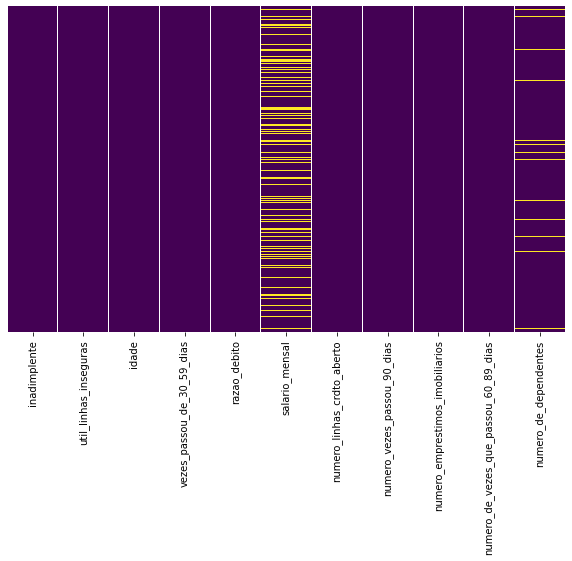

In [5]:
plt.figure(figsize = (10,6))
sns.heatmap(train_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Podemos calcular a porcentagem de dados ausentes encontrados em cada variável.

In [6]:
salario_mensal_ausente= train_df.isnull()['salario_mensal'].value_counts()
percentual_salario_ausente = (salario_mensal_ausente[1])/np.sum(salario_mensal_ausente)
print('{:.4f}% de dados ausentes no salario_mensal.'.format(percentual_salario_ausente*100))

19.7845% de dados ausentes no salario_mensal.


In [7]:
num_dep_ausente=train_df.isnull()['numero_de_dependentes'].value_counts()
percentual_dep_ausente = (num_dep_ausente[1])/np.sum(salario_mensal_ausente)
print('{:.4f}% de dados ausentes no numero_de_dependentes.'.format(percentual_dep_ausente*100))

2.6164% de dados ausentes no numero_de_dependentes.


### Tratamento de dados ausentes

Há dados ausentes nas colunas de numero_de_dependentes e salario_mensal. Na primeira, menos de 3% estão ausentes, é possivel preencher esses dados com a média do parâmetro ou eliminar as linhas com dados ausentes. Como vemos um forte desbalanceamento da classe 1, é mais interessante que, inicialmente, não eliminemos amostras. Então, a primeira opção parece mais interessante.
Já no segundo caso, quase 20% dos dados são faltantes, porém, como espera-se que o salário tenha correlação relativamente forte com a inadimplência, não podemos eliminar a coluna e nem as linhas com dados ausentes. Então, saída para o segundo caso também é preencher esses valores com a média de salarios mensais.

In [8]:
train_df['salario_mensal'].fillna(value = train_df['salario_mensal'].mean(),inplace = True)
train_df['numero_de_dependentes'].fillna(value = train_df['numero_de_dependentes'].mean(),inplace = True)


<AxesSubplot:>

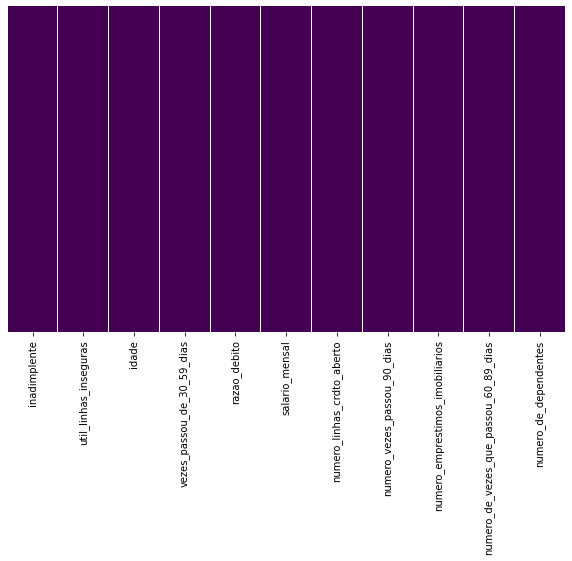

In [9]:
plt.figure(figsize = (10,6))
sns.heatmap(train_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Agora que temos todos os dados presentes, podemos continuar com a análise.
Começamos analisando a correlação entre as variáveis, com foco na inadimplência.

<AxesSubplot:>

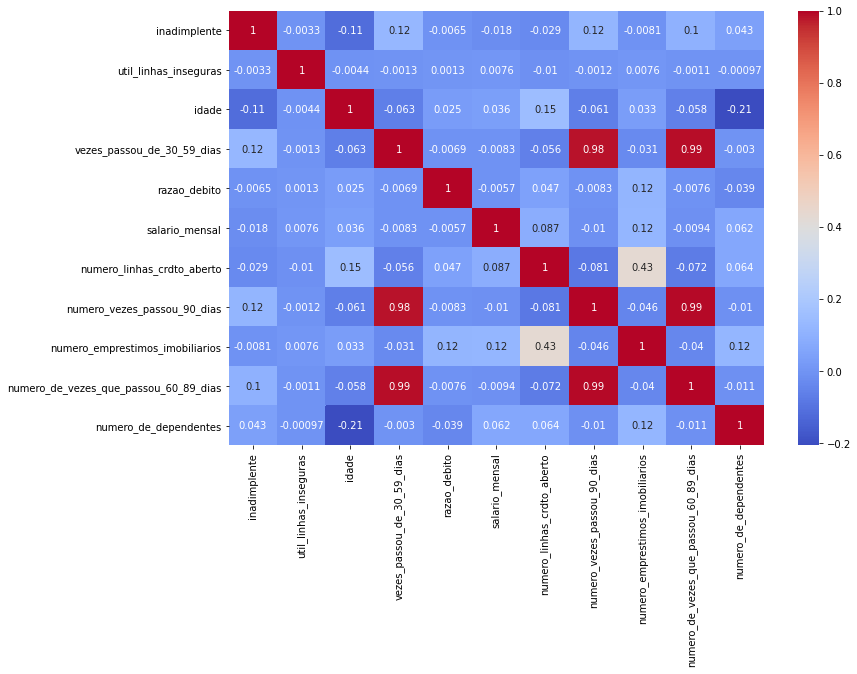

In [10]:
plt.figure(figsize = (12,8))
sns.heatmap(train_df.corr(),cmap='coolwarm',annot= True)

Percebemos correlações mais fortes com idade e número de vezes que atrasou, médias com salário, linhas de debito e número de dependentes e fracas com as demais features. Além disso, as variaveis relacionadas aos atrasos tem forte correlação entre si, o que permite o uso de apenas uma delas.
Dessa forma, escolheu-se trabalhar com as seguintes variáveis: idade, vezes_passou_de_30_59_dias, salario_mensal, numero_linhas_crdto_aberto e numero_de_dependentes.

O próximo passo é a visualização dos dados de maneira geral através de um PairPlot. Esse conjunto de gráficos nos mostra a relação entre as variáveis, bem como nos ajuda a identificar a presença de outliers.

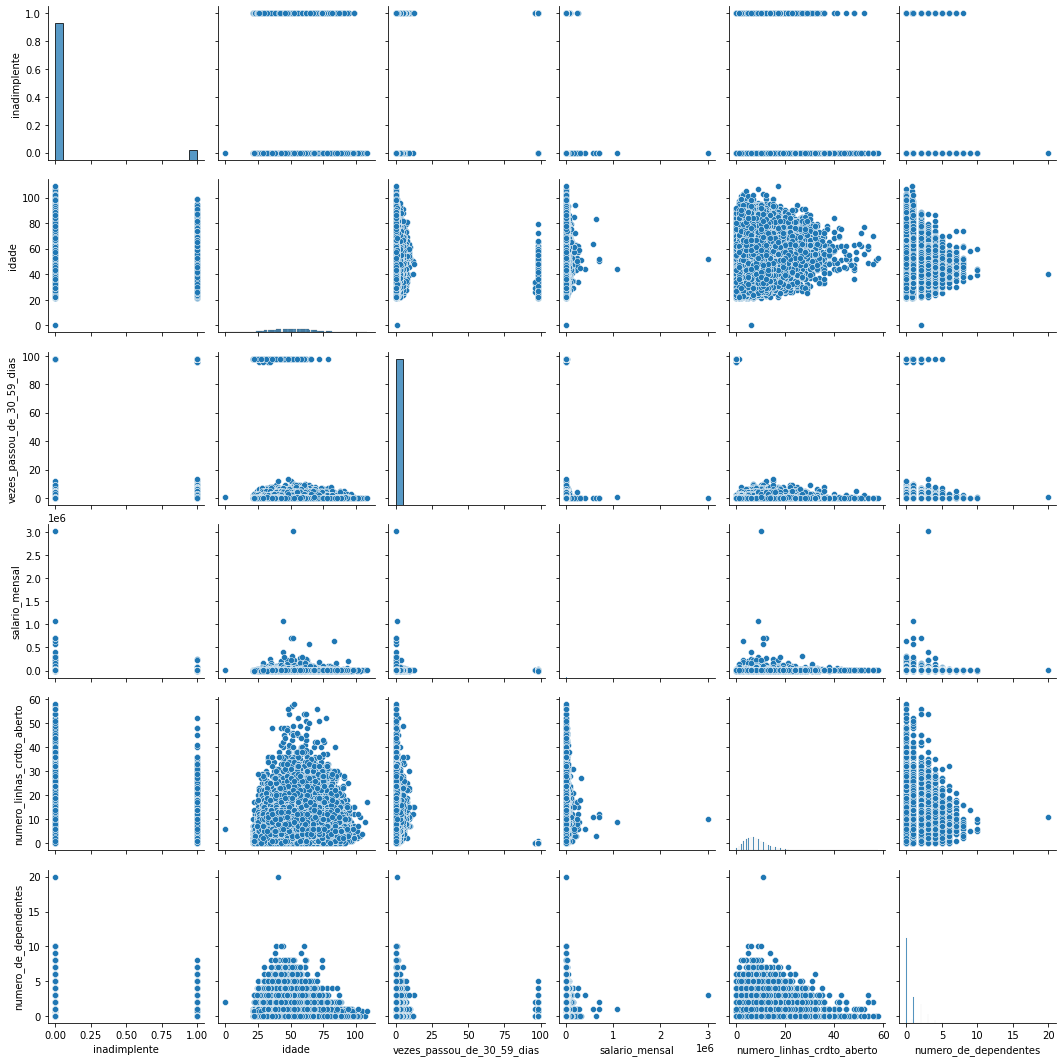

In [11]:
sns.pairplot(data=train_df.drop(['util_linhas_inseguras','numero_de_vezes_que_passou_60_89_dias','razao_debito','numero_vezes_passou_90_dias','numero_emprestimos_imobiliarios'],axis=1))

Verificamos também a presença de outliers nos dados selecionados. Para ter uma melhor compreensão desses eventos, vamos fazer uso de boxplots.

In [12]:
def plot_boxplots(df):
    fig,ax = plt.subplots(1,5,figsize=(17,8))
    ax[0].set_xlabel('idade')
    sns.boxplot(ax=ax[0],data=df['idade'])
    ax[1].set_xlabel('salario_mensal')
    sns.boxplot(ax=ax[1],data=df['salario_mensal'])
    ax[2].set_xlabel('vezes_passou_de_30_59_dias')
    sns.boxplot(ax=ax[2],data=df['vezes_passou_de_30_59_dias'])
    ax[3].set_xlabel('numero_de_dependentes')
    sns.boxplot(ax=ax[3],data=df['numero_de_dependentes'])
    ax[4].set_xlabel('numero_linhas_crdto_aberto')
    sns.boxplot(ax=ax[4],data=df['numero_linhas_crdto_aberto'])

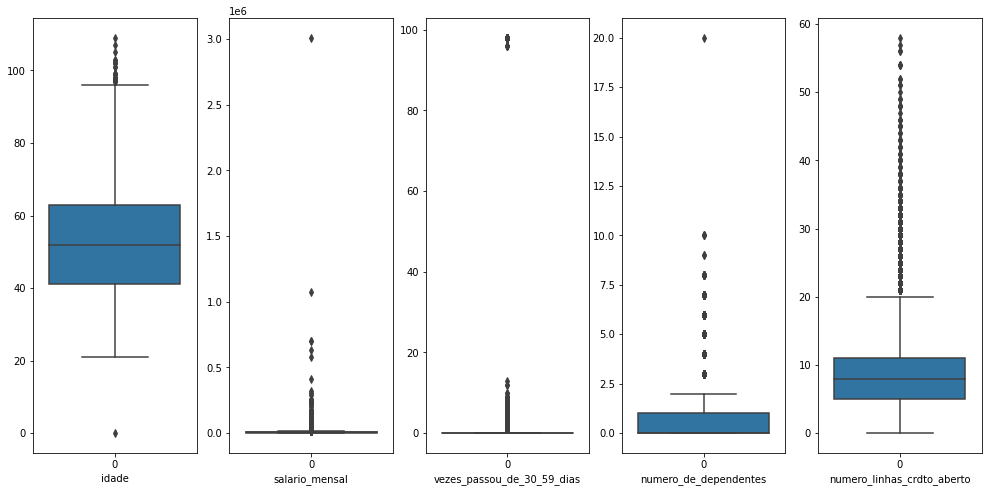

In [13]:
plot_boxplots(train_df)

Como há muitos outliers e alguns muito distantes, realizaremos uma limpeza desses dados. Os valores de threshold foram selecionados de maneira que valores muito distantes fossem removidos, mas que se mantivesse um bom número de amostras da classe minoritária.

In [14]:
train_df.drop(train_df[train_df['idade']>90].index,inplace=True)
train_df.drop(train_df[train_df['idade']<20].index,inplace=True)

train_df.drop(train_df[train_df['salario_mensal']>25000].index,inplace=True)
train_df.drop(train_df[train_df['salario_mensal']<0].index,inplace=True)

train_df.drop(train_df[train_df['numero_linhas_crdto_aberto']>25].index,inplace=True)
train_df.drop(train_df[train_df['numero_linhas_crdto_aberto']<0].index,inplace=True)

train_df.drop(train_df[train_df['vezes_passou_de_30_59_dias']>20].index,inplace=True)
train_df.drop(train_df[train_df['vezes_passou_de_30_59_dias']<0].index,inplace=True)

train_df.drop(train_df[train_df['numero_de_dependentes']>12].index,inplace=True)

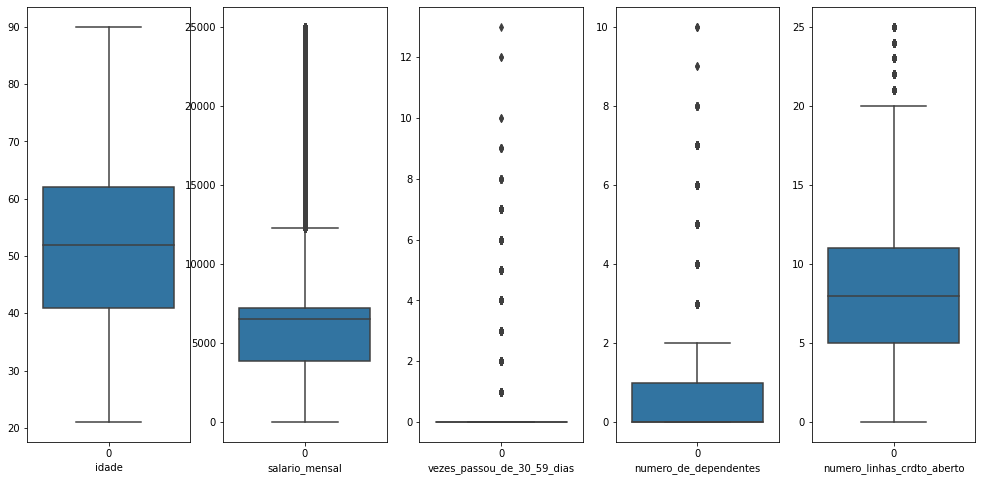

In [15]:
plot_boxplots(train_df)

Como resultado da limpeza, os valores máximos e mínimos das features sofreram grandes alterações, o que irá influenciar positivamente a padronização dos dados mais tarde. Ao mesmo tempo, o número de amostras da classe minoritária perdidos não foi grande, menos de 3%. 

In [16]:
print('Min:{}, Maj:{}'.format(len(train_df[train_df['inadimplente']==1]),len(train_df[train_df['inadimplente']==0])))

Min:7111, Maj:100712


### Padronização e Balanceamento dos dados

Agora vamos verificar o balanceamento do dataset. Caso esteja desbalanceado, podemos realizar um resample.

<AxesSubplot:xlabel='inadimplente', ylabel='count'>

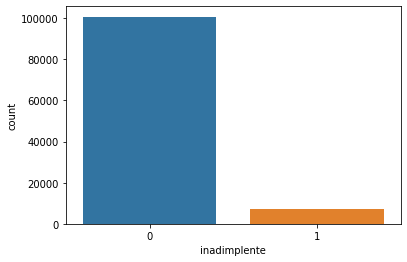

In [17]:
sns.countplot(x = 'inadimplente',data=train_df)

Como podemos perceber, o dataset é extremamente desbalanceado, o que torna necessario o balanceamento.

In [18]:
inadimplente_counts = train_df['inadimplente'].value_counts()
print('0:{}, 1:{}'.format(inadimplente_counts[0],inadimplente_counts[1]))

0:100712, 1:7111


Agora verificamos a discrepância entre as faixas de valores das variáveis.

In [19]:
print('salario Min: {:.2f}, Salario Max:{}'.format(train_df['salario_mensal'].min(),train_df['salario_mensal'].max()))
print('Linhas de credito Min: {:.2f}, Linhas de credito Max:{}'.format(train_df['numero_linhas_crdto_aberto'].min(),train_df['numero_linhas_crdto_aberto'].max()))

salario Min: 0.00, Salario Max:25000.0
Linhas de credito Min: 0.00, Linhas de credito Max:25


Importamos as bibliotecas necessárias para o balanceamento e padronização.

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler,SMOTE,ADASYN,BorderlineSMOTE,SVMSMOTE
from imblearn.combine import SMOTEENN,SMOTETomek
from imblearn.under_sampling import ClusterCentroids,CondensedNearestNeighbour,RandomUnderSampler,TomekLinks
from collections import Counter

Vamos padronizar os dados utilizando o Stantard Scaler. Pois, ela mantém o desvio padrão unitário.

In [21]:
X = train_df.drop(['inadimplente','util_linhas_inseguras','numero_de_vezes_que_passou_60_89_dias','razao_debito','numero_vezes_passou_90_dias','numero_emprestimos_imobiliarios'],axis=1)
y = train_df['inadimplente']

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

Vamos dividir os dados de treino e teste do dataset padronizado e desbalanceado para fins de comparação, utilizando random_state = 101 para replicabilidade.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=101)

Agora utilizamos uma tecnica de resample para balancear o dataframe. Algumas técnicas podem ser interessantes, tanto oversampling da classe minoritária, quanto undersampling da majoritária ou mesmo a combinação dos dois podem ser utilizados.

In [23]:
sm = SMOTE(sampling_strategy=0.65)
X_balanceado, y_balanceado = sm.fit_resample(X,y)
print(Counter(y),Counter(y_balanceado))

Counter({0: 100712, 1: 7111}) Counter({0: 100712, 1: 65462})


Após testes com as diversas técnicas, a que apresentou melhores resultados foi a SMOTE com ratio de 0.65, gerando amostras sintéticas da classe minoritária.

Agora dividimos o dataframe balanceado e padronizado para treinamento dos modelos.

In [24]:
X_train_balanceado, X_test_balanceado, y_train_balanceado, y_test_balanceado = train_test_split(X_balanceado, y_balanceado, test_size=0.25,random_state=101)

## Escolha e treinamento do modelo e critério de avaliação

Com os dados devidamente tratados, é hora de escolher o modelo. Como o problema envolve apenas a predição de uma variável com dois estados, muitos modelos podem ser viáveis. Vamos implementar os seguintes: **Regressão Logística, Árvores de Decisão e Florestas Aleatórias** utilizando a biblioteca Scikit Learn, **XGBoost** utilizando a biblioteca xgboost e **redes neurais** utilizando Pytorch. A escolha dos frameworks se deu por conta da simplicidade de implementação, ferramentas disponíveis e gosto pessoal. Em todos os casos, a predição levará em conta a maior probabilidade encontrada.

Cada modelo será implementado da forma mais simples, para triagem inicial. O modelo que apresentar melhor resultado nessa etapa, segue para uma etapa de ajuste paramétrico usando GrindSearch.

No que diz respeito as métricas de avaliação, serão utilizadas aurácia balanceada, F1, recall e matriz de confusão. Para tal, uma função de avaliação do modelo será implementada.
Serão avaliados os modelos em relação ao dataframe balanceado e ao desbalanceado, mantendo apenas a padronização de valores.

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score,precision_score,recall_score,confusion_matrix,classification_report,balanced_accuracy_score
from sklearn.model_selection import cross_validate,cross_val_score,GridSearchCV

import xgboost as xgb


In [26]:
def evaluate_model(targets,predictions):
    scores_dict = {}
    methods = [balanced_accuracy_score,f1_score,recall_score,confusion_matrix]
    scores = [x(targets,predictions) for x in methods]
    scores_dict['balanced_accuracy'] = scores[0]
    scores_dict['f1'] = scores[1]
    scores_dict['recall'] = scores[2]
    scores_dict['confusion_matrix'] = scores[3]
    
    print('Balanced Accuracy:{:.4f}'.format(balanced_accuracy_score(targets,predictions)))
    print('F1:{:.4f}'.format(f1_score(targets,predictions)))
    print('Recall:{:.4f}'.format(recall_score(targets,predictions)))
    print('Confusion matrix: \n',confusion_matrix(targets,predictions))
    ax = sns.heatmap(confusion_matrix(targets,predictions),cmap='coolwarm',annot=False)
    ax.set(xlabel = 'Predicted',ylabel='Target')
    
    return scores_dict
    

### Regressão logística

Começamos pelo modelo mais simples, a regressão logística. Realizamos a declaração e o ajuste do modelo nos dados balanceados.

In [27]:
log_model = LogisticRegression(max_iter = 100)
log_model.fit(X_train_balanceado,y_train_balanceado)


LogisticRegression()

Agora fazemos as predições tanto para os dados balanceados, quanto para os desbalanceados.

In [28]:
log_predictions = log_model.predict(X_test)
log_predictions_balanceado = log_model.predict(X_test_balanceado)

Balanced Accuracy:0.6669
F1:0.5503
Recall:0.4435
Confusion matrix: 
 [[22395  2760]
 [ 9121  7268]]


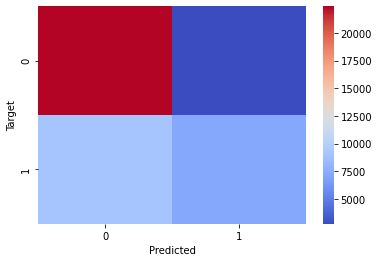

In [29]:
scores_log_balanceado = evaluate_model(y_test_balanceado,log_predictions_balanceado)


Balanced Accuracy:0.6636
F1:0.2839
Recall:0.4378
Confusion matrix: 
 [[22465  2794]
 [  954   743]]


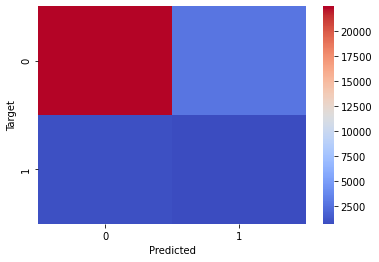

In [30]:
scores_log = evaluate_model(y_test,log_predictions)

### Árvore de Decisão

O modelo seguinte é o de arvores de decisão e será implementado e avaliado de maneira análoga ao anterior.

In [31]:
tree_model = LogisticRegression(max_iter = 100)
tree_model.fit(X_train_balanceado,y_train_balanceado)

LogisticRegression()

In [32]:
tree_predictions_balanceado = tree_model.predict(X_test_balanceado)
tree_predictions = tree_model.predict(X_test)

Balanced Accuracy:0.6669
F1:0.5503
Recall:0.4435
Confusion matrix: 
 [[22395  2760]
 [ 9121  7268]]


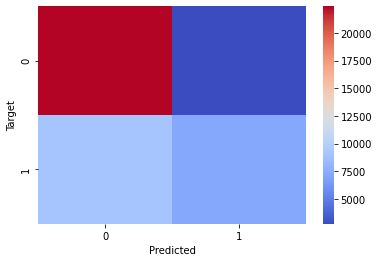

In [33]:
scores_tree_balanceado = evaluate_model(y_test_balanceado,tree_predictions_balanceado)


Balanced Accuracy:0.6636
F1:0.2839
Recall:0.4378
Confusion matrix: 
 [[22465  2794]
 [  954   743]]


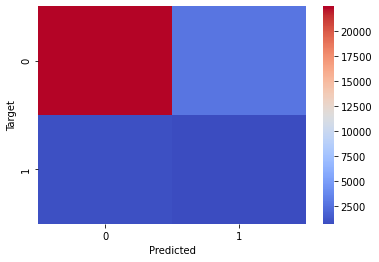

In [34]:
scores_tree = evaluate_model(y_test,tree_predictions)

### Florestas Áleatórias

Faremos o mesmo para florestas aleatórias.

In [35]:
rfc_model= RandomForestClassifier(n_jobs=-1)
rfc_model.fit(X_train_balanceado,y_train_balanceado)

RandomForestClassifier(n_jobs=-1)

In [36]:
rfc_predictions_balanceado = rfc_model.predict(X_test_balanceado)
rfc_predictions = rfc_model.predict(X_test)

Balanced Accuracy:0.9063
F1:0.8883
Recall:0.8731
Confusion matrix: 
 [[23635  1520]
 [ 2080 14309]]


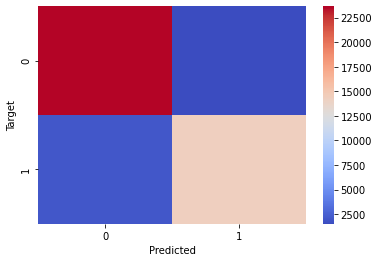

In [37]:
scores_rfc_balanceado = evaluate_model(y_test_balanceado,rfc_predictions_balanceado)


Balanced Accuracy:0.8512
F1:0.6911
Recall:0.7278
Confusion matrix: 
 [[24617   642]
 [  462  1235]]


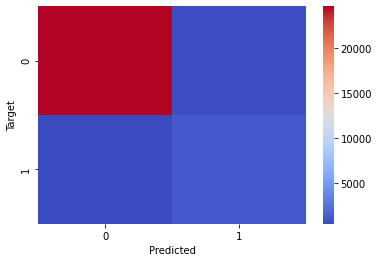

In [38]:
scores_rfc = evaluate_model(y_test,rfc_predictions)

### XGBoost

Como esse modelo apresenta muitos parâmetros e é sensivel a eles, será implementado um Grid Search básico, buscando uma melhor noção do potencial do método. 

In [39]:
xgb_params = {'learning_rate':[0.3,0.4],'max_depth':[11],'subsample':[0.9],'colsample_bytree':[0.05,0.1], 
              'n_estimators':[400,500,600],'objective':['binary:logistic'] }

In [40]:
#xgb_model = xgb.XGBClassifier()
#xgb_grid_search = GridSearchCV(estimator = xgb_model, param_grid = xgb_params, cv=5,verbose = 0,scoring='f1',n_jobs=-1)
#xgb_grid_search.fit(X_train_balanceado,y_train_balanceado)

In [41]:
#xgb_melhores_param = xgb_grid_search.best_params_
#print(xgb_melhores_param)

Os parametros encontrados pelo GridSearch foram os seguintes:

In [42]:
xgb_melhores_param = {'colsample_bytree': 0.05, 'learning_rate': 0.3, 'max_depth': 11, 'n_estimators': 600, 'objective': 'binary:logistic', 'subsample': 0.9}

In [43]:
xgb_model = xgb.XGBClassifier(
    n_estimators =xgb_melhores_param['n_estimators'],
    colsample_bytree =xgb_melhores_param['colsample_bytree'],
    learning_rate =xgb_melhores_param['learning_rate'],
    max_depth =xgb_melhores_param['max_depth'],
    objective =xgb_melhores_param['objective'],
    subsample =xgb_melhores_param['subsample'],
    use_label_encoder=False
)

In [44]:
xgb_model.fit(X_train_balanceado,y_train_balanceado)

[14:30:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.05, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=11,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=600, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [45]:
xgb_pred_balanceado = xgb_model.predict(X_test_balanceado)
xgb_pred = xgb_model.predict(X_test)

Balanced Accuracy:0.9173
F1:0.9074
Recall:0.8501
Confusion matrix: 
 [[24766   389]
 [ 2456 13933]]


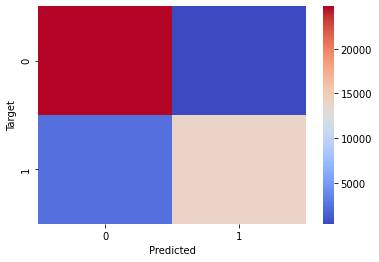

In [46]:
scores_xgb_balanceado = evaluate_model(y_test_balanceado,xgb_pred_balanceado)

Balanced Accuracy:0.5506
F1:0.1759
Recall:0.1120
Confusion matrix: 
 [[24986   273]
 [ 1507   190]]


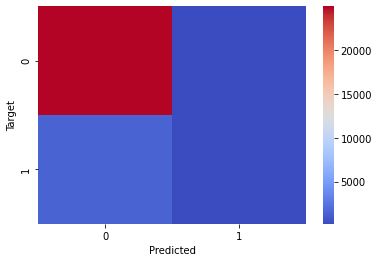

In [47]:
scores_xgb = evaluate_model(y_test,xgb_pred)

### Rede Neural com Pytorch

A implementação de uma rede neural pode ser interessante por conta do nível de ajuste possível.

In [48]:
import torchvision.transforms as tf
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F

Após as importações necessárias, podemos transformar os dados em tensores e já estruturalos no formato (feature,label) o que facilita o tratamento desses dados na rede.

In [49]:
dataset_balanceado = []

for i,(features,label) in enumerate(zip(X_balanceado,y_balanceado)):
    
    dataset_balanceado.append([torch.tensor([features],dtype=torch.float),torch.tensor(label,dtype=torch.float)])

dataset = []
for i,(features,label) in enumerate(zip(X,y)):
    
    dataset.append([torch.tensor([features],dtype=torch.float),torch.tensor(label,dtype=torch.float)])

Dividimos o conjunto em treino e teste numa proporção de 25% treino e criamos os dataloaders.

In [50]:
train_size_balanceado = int(0.75*len(dataset_balanceado))
val_size_balanceado = len(dataset_balanceado) - train_size_balanceado

train_ds_balanceado,val_ds_balanceado = random_split(dataset_balanceado,[train_size_balanceado,val_size_balanceado])
batch_size = 64
train_loader_balanceado = DataLoader(train_ds_balanceado,batch_size,shuffle=True)
val_loader_balanceado = DataLoader(val_ds_balanceado,batch_size,shuffle=False)

train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size

train_ds,val_ds = random_split(dataset,[train_size,val_size])
train_loader = DataLoader(train_ds,batch_size,shuffle=True)
val_loader = DataLoader(val_ds,batch_size,shuffle=False)

Funções avaliação de recall e accurary foram criadas para  facilitar o uso dentro da classe modelo durante a etapa de validação.

In [51]:
def torch_recall_score(out,labels):
    tp = 0
    fn = 0
    preds =[round(x.item()) for x in out]
    all_zeros_flag = 1
    for i in range(len(labels)):
        
        if labels[i] == 1:
            all_zeros_flag = 0
            if (preds[i]==1):
                tp +=1
            elif (preds[i]==0):
                fn+=1
            
    if all_zeros_flag==0:
        recall = torch.tensor(tp/(tp+fn))
    else:
        recall =torch.tensor(0)
    return recall

In [52]:
def torch_accuracy_score(out, labels):
    acertos = 0
    preds =[round(x.item()) for x in out]
    for i in range(len(labels)):
        if labels[i] == preds[i]:
            acertos+=1
            
    acc = acertos/(len(labels))
    return torch.tensor(acc)

Agora implementamos o modelo. Serão utilizados 5 features na entrada, uma camada densa escondida de 15 neuronios, mais uma de 30, outra de 15 gerando a saída de 1, que passa por uma função de ativação do tipo Sigmoid. Em cada uma das camadas densas foi utilizada uma função de ativação LeakyReLU, para manter tracking dos valores negativos, já que StandardScaler tem saida entre -1 e 1.
A quantidade de camadas e tamanho das mesmas foi obtida por por testes, sendo este o melhor resultado encontrado.

In [53]:
class modelo(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(5,15),
            nn.LeakyReLU(),
            nn.Linear(15,30),
            nn.LeakyReLU(),
            nn.Linear(30,15),
            nn.LeakyReLU(),
            nn.Linear(15,1),           
            
            nn.Sigmoid()
        )
        
    def forward(self, xb):
        out = self.network(xb)
        return out
    
    def training_step(self, batch):
        features, labels = batch 
        labels =labels.reshape(-1,1)
        out = self(features).reshape(-1,1)                 
        loss = F.binary_cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        features, labels = batch 
        labels =labels.reshape(-1,1)
        out = self(features).reshape(-1,1)
        loss = F.binary_cross_entropy(out, labels)   
        recall = torch_recall_score(out,labels)
        acc = torch_accuracy_score(out,labels)
        return {'val_loss': loss, 'val_recall': recall,'val_acc':acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_recalls = [x['val_recall'] for x in outputs]
        epoch_recall = torch.stack(batch_recalls).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  
        return {'val_loss': epoch_loss.item(), 'val_recall': epoch_recall.item(),'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_recall: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_recall'],result['val_acc']))


A função evaluate passa cada batch do dataloader de validação para passa-los pra função de validação do final de cada epoca, na qual são tiradas as médias para impressão na tela.

In [54]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [55]:
def fit(epochs,lr,model,train_loader,val_loader,opt_func = torch.optim.Adam):
    optmizer = opt_func(model.parameters(),lr)
    
    for epoch in range(epochs):
        for batch in train_loader:
            optmizer.zero_grad()
            loss = model.training_step(batch)
            loss.backward()
            optmizer.step()
            
            
        with torch.no_grad():   
            results = evaluate(model,val_loader)
            model.epoch_end(epoch,results)

In [56]:
def predict(features,model):
    pred = model(features)
    pred = [round(x.item()) for x in pred ]
    return pred

In [57]:
model =  modelo()
lr = 0.001
epochs = 10
fit(epochs,lr,model,train_loader_balanceado,val_loader)

Epoch [0], val_loss: 0.4339, val_recall: 0.5525, val_acc: 0.8375
Epoch [1], val_loss: 0.4356, val_recall: 0.5569, val_acc: 0.8364
Epoch [2], val_loss: 0.4412, val_recall: 0.5926, val_acc: 0.8223
Epoch [3], val_loss: 0.4148, val_recall: 0.5514, val_acc: 0.8433
Epoch [4], val_loss: 0.4367, val_recall: 0.5819, val_acc: 0.8252
Epoch [5], val_loss: 0.4267, val_recall: 0.5702, val_acc: 0.8361
Epoch [6], val_loss: 0.4476, val_recall: 0.5803, val_acc: 0.8288
Epoch [7], val_loss: 0.4294, val_recall: 0.5682, val_acc: 0.8352
Epoch [8], val_loss: 0.4621, val_recall: 0.6079, val_acc: 0.8129
Epoch [9], val_loss: 0.4315, val_recall: 0.5768, val_acc: 0.8321


Com o modelo treinado, tiramos as predições para avaliação.

In [58]:
nn_predictions = [predict(x[0],model) for x in val_ds]
nn_predictions_balanceado = [predict(x[0],model) for x in val_ds_balanceado]

In [59]:
nn_labels = [x[1] for x in val_ds]
nn_labels_balanceado = [x[1] for x in val_ds_balanceado]

Balanced Accuracy:0.7141
F1:0.3160
Recall:0.5775
Confusion matrix: 
 [[21397  3753]
 [  763  1043]]


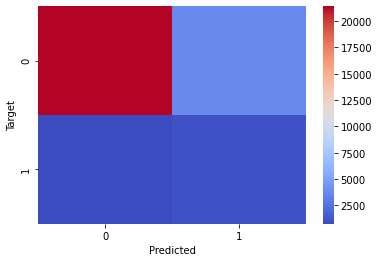

In [60]:
scores_nn = evaluate_model(nn_labels,nn_predictions)

Balanced Accuracy:0.7047
F1:0.6251
Recall:0.5563
Confusion matrix: 
 [[21386  3686]
 [ 7308  9164]]


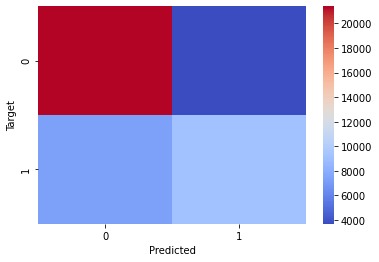

In [61]:
scores_nn_balanceado = evaluate_model(nn_labels_balanceado,nn_predictions_balanceado)

 Entre os 5 modelos, o que apresentou melhores resultados iniciais foi o de florestas aleatórias. Assim, ele foi o modelo selecionado.

## Melhorando o modelo selecionado

Para o modelo de de árvores de decisão, os hyperparametros principais disponiveis são:
- criterion
- n_estimators
- max_features
- max_depth
 
A busca pelos melhores parametros será feita com o Grid Search.
Além disso, podemos buscar por melhores proporções para o balanceadmento. Então, definimos uma função que busca o melhor ratio utilizando validação cruzada com critério F1 

In [62]:
def ratio_search(ratio,parametros,X,y):
    
    sm = SMOTE(sampling_strategy=ratio)
    X_balanceado, y_balanceado = sm.fit_resample(X,y)
    X_train_balanceado, X_test_balanceado, y_train_balanceado, y_test_balanceado = train_test_split(X_balanceado,
                                                                                                    y_balanceado,
                                                                                                    test_size=0.25,
                                                                                                    random_state=101)
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=101)
    
    rfc_final_model = RandomForestClassifier(n_estimators = parametros['n_estimators'],
                                             criterion = parametros['criterion'],                                        
                                             max_features=parametros['max_features'],
                                             max_depth=parametros['max_depth'],n_jobs=-1)
    rfc_final_model.fit(X_train_balanceado,y_train_balanceado)
    
    scores = cross_validate(estimator = rfc_final_model,X=X_test,y=y_test,scoring = 'f1',cv=5,n_jobs=-1,return_estimator=False)
    
    return scores['test_score'].mean()

In [63]:
parametros = {'n_estimators':[100,300,500],
             'criterion':['gini','entropy'],
             'max_features':['auto',4,5],
             'max_depth':[None,3,7,11]
             }

In [64]:
#rfc_final_model =  RandomForestClassifier()
#grid_search = GridSearchCV(estimator = rfc_final_model, param_grid = parametros,
#                           cv=5,verbose = 0,
#                           scoring='f1',refit=True,
#                           n_jobs=-1)
#grid_search.fit(X_train_balanceado,y_train_balanceado)


In [65]:
#melhores_param = grid_search.best_params_
#print(melhores_param)

Os resultados abaixo foram encontrados após o Grid Search

In [66]:
melhores_param ={'criterion': 'entropy', 'max_depth': None, 'max_features': 5, 'min_samples_split': 4, 'n_estimators': 500}

Agora que temos os melhores parametros, buscamos a melhor proporção do balanceamento.

In [67]:
ratios = [0.6,0.65,0.7]
melhor_score = 0
melhor_ratio = 0
for ratio in ratios:
    score_atual = ratio_search(ratio,melhores_param,X=X,y=y)
    print('Ratio: {:.2f}, score_atual:{:.4f}'.format(ratio,score_atual))
    
    if score_atual>= melhor_score:
        melhor_score =score_atual
        melhor_ratio = ratio

Ratio: 0.60, score_atual:0.1116
Ratio: 0.65, score_atual:0.1115
Ratio: 0.70, score_atual:0.1118


In [68]:
print(melhor_ratio)

0.7


In [69]:
sm = SMOTE(sampling_strategy=melhor_ratio)
X_balanceado, y_balanceado = sm.fit_resample(X,y)
X_train_balanceado, X_test_balanceado, y_train_balanceado, y_test_balanceado = train_test_split(X_balanceado, y_balanceado, test_size=0.25,random_state=101)

Utilizando os melhores parâmetros encontrados, treinamos o modelo final.

In [70]:
rfc_final_model = RandomForestClassifier(n_estimators = melhores_param['n_estimators'],
                                         criterion = melhores_param['criterion'],
                                         max_features=melhores_param['max_features'],                                    
                                         max_depth = melhores_param['max_depth'],
                                         n_jobs=-1)

rfc_final_model.fit(X_train_balanceado,y_train_balanceado)

final_model_preds_b = rfc_final_model.predict(X_test_balanceado)
final_model_preds = rfc_final_model.predict(X_test)

Balanced Accuracy:0.9231
F1:0.9110
Recall:0.8976
Confusion matrix: 
 [[23821  1293]
 [ 1811 15878]]


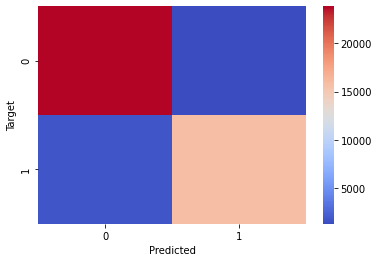

In [71]:
scores_rfc_final_balanceado = evaluate_model(y_test_balanceado,final_model_preds_b)

Balanced Accuracy:0.8429
F1:0.7035
Recall:0.7060
Confusion matrix: 
 [[24748   511]
 [  499  1198]]


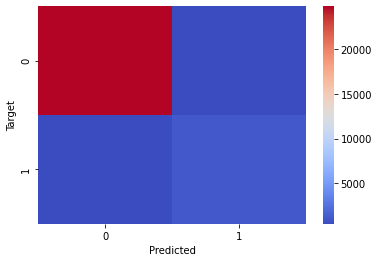

In [72]:
scores_rfc_final = evaluate_model(y_test,final_model_preds)

In [73]:
print(classification_report(y_test,final_model_preds))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     25259
           1       0.70      0.71      0.70      1697

    accuracy                           0.96     26956
   macro avg       0.84      0.84      0.84     26956
weighted avg       0.96      0.96      0.96     26956



Como podemos perceber, houve uma melhora no número de falsos positivos e nas métricas em geral. O próximo passo então é aplicação do modelo no dadaset de teste.

## Predição dos dados do teste.csv

Importamos os dados de teste, visualizamos e buscamos por dados ausentes.

In [74]:
teste_df = pd.read_csv('teste.csv')
teste_df_original =  teste_df.copy()

In [75]:
teste_df.head()

,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
0,0.025849,62,0,0.081775,8180.0,3,0,2,0,0.0
1,0.667083,55,0,0.153112,2200.0,3,0,0,0,0.0
2,0.007093,44,0,0.148800,7499.0,20,0,1,0,0.0
3,0.091213,54,0,0.351635,5900.0,15,0,1,1,0.0
4,0.112680,54,0,0.065959,2167.0,3,0,0,0,0.0


In [76]:
teste_df.count()

util_linhas_inseguras                    40000
idade                                    40000
vezes_passou_de_30_59_dias               40000
razao_debito                             40000
salario_mensal                           32032
numero_linhas_crdto_aberto               40000
numero_vezes_passou_90_dias              40000
numero_emprestimos_imobiliarios          40000
numero_de_vezes_que_passou_60_89_dias    40000
numero_de_dependentes                    38954
dtype: int64

Para aplicação do modelo, devemos limpar e padronizar os dados de teste.

### Limpando os dados de teste

<AxesSubplot:>

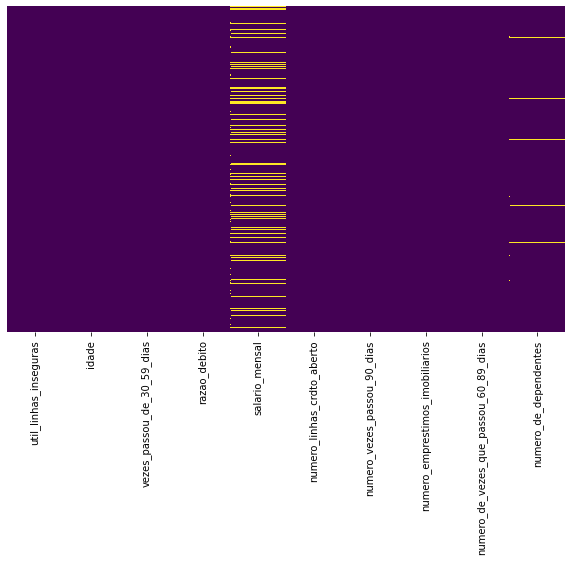

In [77]:
plt.figure(figsize = (10,6))
sns.heatmap(teste_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Como queremos prever a inadimplencia de para todas as entradas, preencheremos os valores ausentes com a média novamente.

In [78]:
teste_df['salario_mensal'].fillna(value = teste_df['salario_mensal'].mean(),inplace = True)
teste_df['numero_de_dependentes'].fillna(value = teste_df['numero_de_dependentes'].mean(),inplace = True)

<AxesSubplot:>

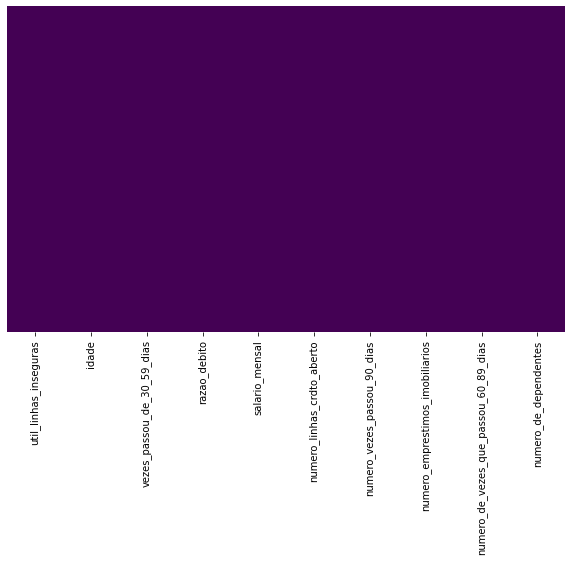

In [79]:
plt.figure(figsize = (10,6))
sns.heatmap(teste_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

O uso dos boxplots novamente nos ajuda a ver a existência de outliers.

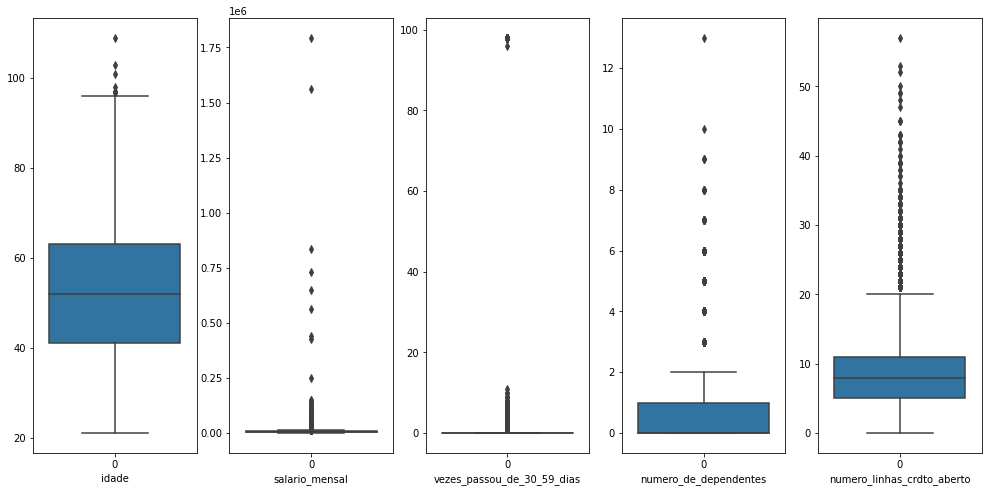

In [80]:
plot_boxplots(teste_df)

Com os dados ausentes tratados, é hora de padroniza-los. Para tal utilizamos a mesma StandardtScaler utilizada nos dados de treino. Pois, utilizar um novo Scaler, ajustado para os dados de teste, fará com que as proporções sejam muito diferentes, visto que há outliers grandes nos dados de teste. 

In [81]:
X_teste_final = teste_df.drop(['util_linhas_inseguras','numero_de_vezes_que_passou_60_89_dias','razao_debito','numero_vezes_passou_90_dias','numero_emprestimos_imobiliarios'],axis=1)
X_teste_final = scaler.transform(X_teste_final)

Com os dados padronizados, podemos realizar as previsões.

In [82]:
teste_predictions = rfc_final_model.predict(X_teste_final)

In [83]:
teste_predictions

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [84]:
unique,counts = np.unique(teste_predictions,return_counts=True)
list(zip(unique,counts))

[(0, 37360), (1, 2640)]

Com as previsões feitas, podemos salva-las no arquivo de teste.

In [85]:
teste_df_original['inadimplente'] = teste_predictions
teste_df_original.head()
teste_df_original.to_csv('teste_com_pred.csv',index=False)